In [1]:
import sys
from pathlib import Path

# Add the root project folder to the python path in order to use the packages
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from scipy import sparse
from tqdm import tqdm
from importlib import reload

import reservoirpy
reservoirpy.verbosity(0)

# SEED
SEED = 49387

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Reservoir functions

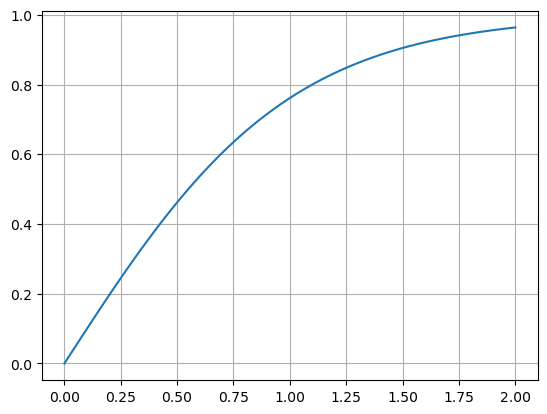

In [3]:
from reservoir.activation_functions import tanh, heaviside, sigmoid

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

# Datasets

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Classification: 
https://arxiv.org/abs/1803.07870

https://github.com/FilippoMB/Time-series-classification-and-clustering-with-Reservoir-Computing

Multivariate:
https://www.timeseriesclassification.com/dataset.php

## Prediction ahead

### Mackey-Glass


In [ ]:
from reservoirpy.datasets import mackey_glass

timesteps = 15000
mg_inputs = mackey_glass(timesteps, tau=17, a=0.2, b=0.1, n=10, x0=1.2, h=1, seed=None)

# Define the time step of your Mackey-Glass system
dt = 0.00001

# Compute the equivalent sampling rate
sampling_rate = 1 / dt

is_multivariate = False
step_ahead = 5

X_pretrain = mg_inputs[:5000]

X_train = mg_inputs[5000:10000-step_ahead]
Y_train = mg_inputs[5000+step_ahead:10000]

X_test = mg_inputs[10000-step_ahead:15000-step_ahead-step_ahead]
Y_test = mg_inputs[10000:15000-step_ahead]


plt.figure(figsize=(16,5))
plt.plot(range(500), X_test[:500])
plt.plot(range(500), Y_test[:500])
plt.show()

## Classification

### Japanese voyels

In [4]:
from reservoirpy.datasets import japanese_vowels

X_train_band, Y_train, X_test_band, Y_test = japanese_vowels()

is_multivariate = True

# Sampling rate : 10 kHz
# Source : https://archive.ics.uci.edu/dataset/128/japanese+vowels
sampling_rate = 10000

# pretrain is the same as train
X_pretrain = np.concatenate(X_train_band, axis=0)
# here pretrain is already multivariate and we don't need to extract harmonics, therefore we can directly use the data
filtered_data = X_pretrain.T

Y_train = np.squeeze(np.array(Y_train), axis=1)
Y_test = np.squeeze(np.array(Y_test), axis=1)
Y_train.shape

(270, 9)

### InsectWingbeat

### MELD

https://github.com/declare-lab/MELD


### Free Spoken Digits Dataset

In [ ]:
from datasets.load_datasets import load_FSDD_dataset

data_dir = 'datasets/fsdd/free-spoken-digit-dataset-master/recordings'  # Path to the extracted dataset
sampling_rate, X_train, X_test, Y_train, Y_test = load_FSDD_dataset(data_dir, seed=SEED)
# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

#take a long time (15min with half the samples, instant with 20 which is enought for pretraining)
X_pretrain = np.concatenate(X_train[:20], axis=0)
print(X_pretrain.shape)

is_multivariate = False

## Multivariate generation if necessary

Spectrograms_vs_Cochleagrams : https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

### Spectral density and peak selection

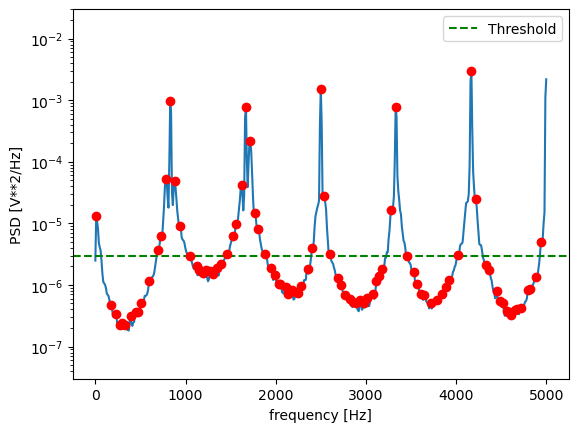

Filtered peak frequencies:  [   9.765625  693.359375  722.65625   781.25      830.078125  878.90625
  937.5      1455.078125 1523.4375   1562.5      1621.09375  1669.921875
 1718.75     1767.578125 1806.640625 1884.765625 2402.34375  2500.
 2539.0625   2597.65625  3281.25     3330.078125 4023.4375   4169.921875
 4218.75     4941.40625 ]
Number of frequencies selected : 26


In [6]:
from datasets.multivariate_generation import extract_peak_frequencies

filtered_peak_freqs = extract_peak_frequencies(X_pretrain.flatten(), sampling_rate, threshold=1e-3, nperseg=1024, visualize=True)

print("Number of frequencies selected :", len(filtered_peak_freqs))

### Applying normal band pass filter on data

In [7]:
import datasets.multivariate_generation 
reload(datasets.multivariate_generation)
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

if not is_multivariate:
    X_pretrain_band, X_train_band, X_test_band = generate_multivariate_dataset(
        filtered_peak_freqs, X_pretrain, X_train, X_test, sampling_rate, nb_jobs=-1
    )

### Standardizing the amplitudes

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

if not is_multivariate:
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # pretrain
    filtered_data = scaler.fit_transform(X_pretrain_band)

    if len(X_train[0].shape)>1:
        # train
        X_train_band = [
            np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() 
                      for time_serie in x]) for x in tqdm(X_train_band)
        ]
    
        # test
        X_test_band = [
            np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() 
                      for time_serie in x]) for x in tqdm(X_test_band)
        ]
    else: 
        # train
        X_train_band = np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in X_train_band])
    
        # test
        X_test_band = np.array([scaler.fit_transform(time_serie.reshape(-1, 1)).flatten() for time_serie in X_test_band])
        

# Generating reservoirs

## Plot  pretrain dataset

In [9]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/filtered_peak_freqs[-1]

min_window_size

2.0237154150197627

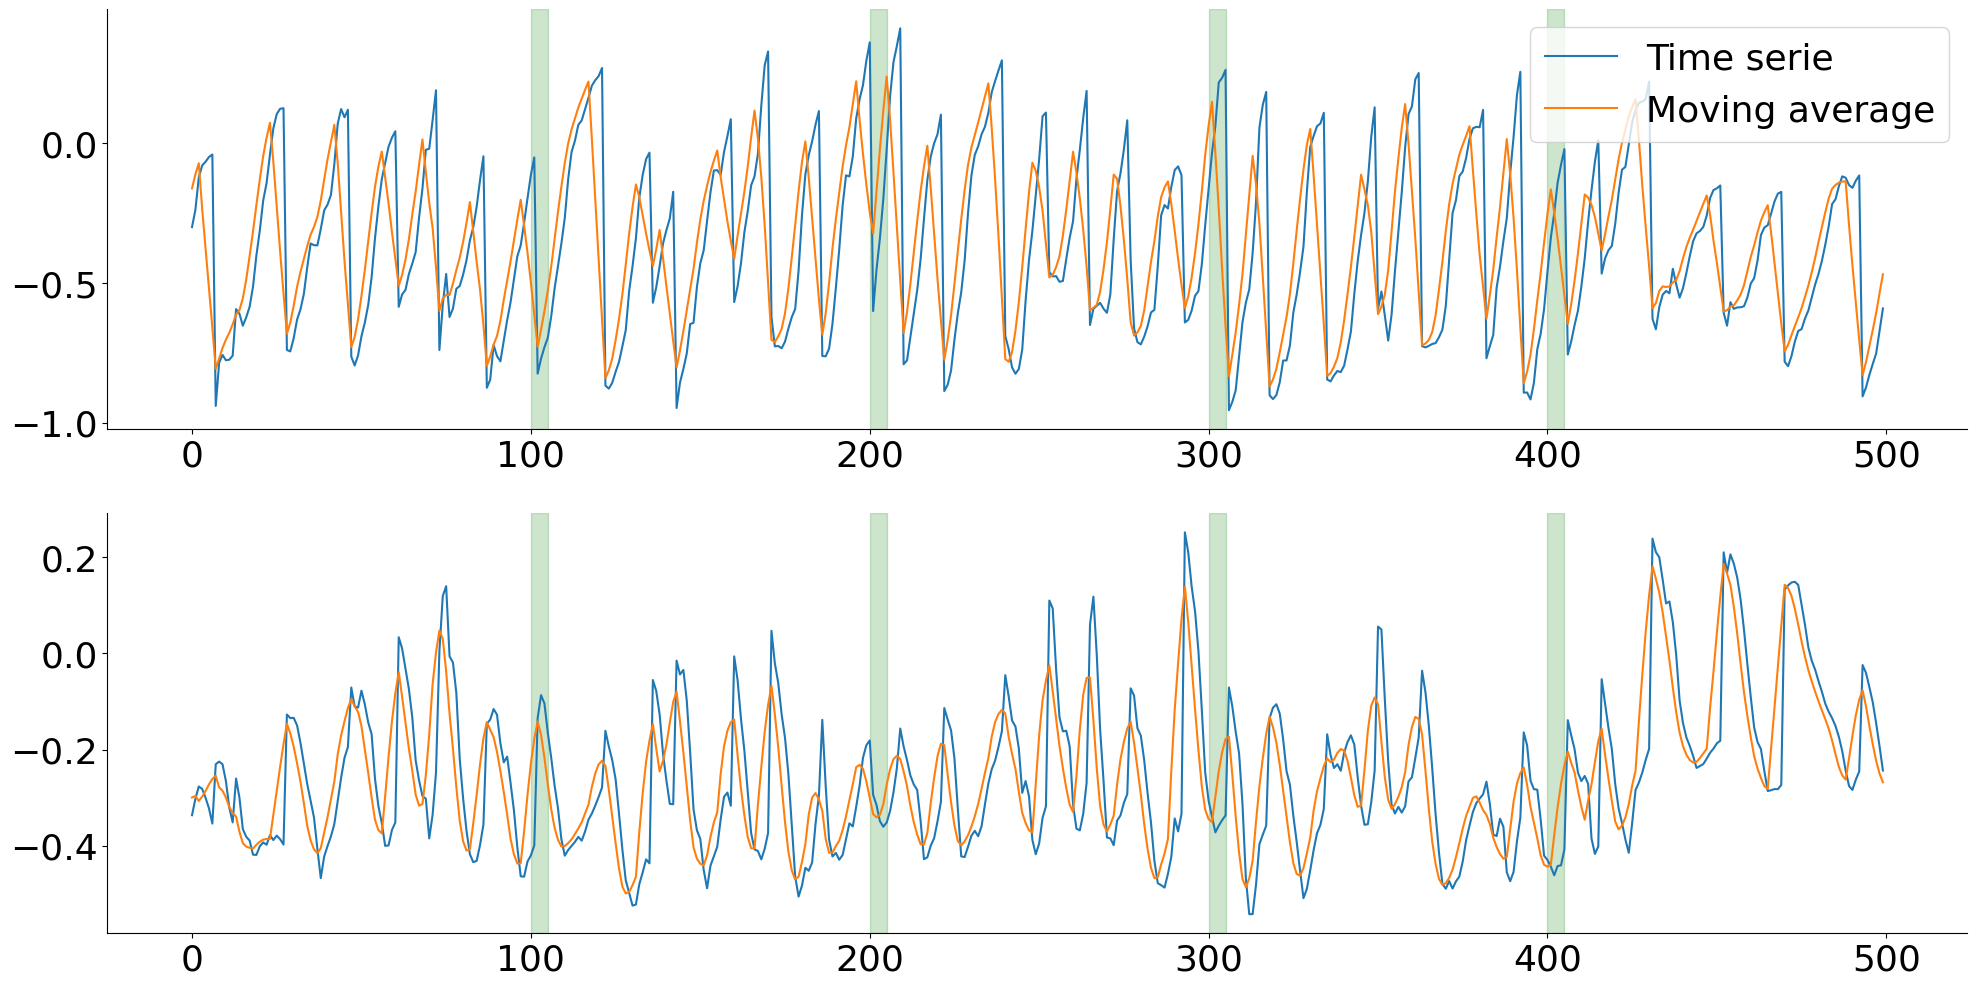

In [10]:
#Compute the moving average 
window_size = 5
weights = np.repeat(1.0, window_size)/window_size
ma = np.array([np.convolve(d, weights, 'valid') for d in (filtered_data)])

#CPlot the two for different frequencies
NB_1 = 3
fig, ax = plt.subplots(2, 1, figsize=(24,12))
ax[0].plot(range(500), filtered_data[NB_1, 1000:1500], label='Time serie')
ax[0].plot(range(500), ma[NB_1, 1000:1500], label='Moving average')
NB_2 = 8
ax[0].legend(fontsize=26)
ax[1].plot(range(500), filtered_data[NB_2, 1000:1500], label='Time serie')
ax[1].plot(range(500), ma[NB_2, 1000:1500], label='Moving average')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', labelsize=26)
ax[1].tick_params(axis='both', labelsize=26)


# draw vertical lines to represent the window for some points
for x in range(100, 500, 100):
    ax[0].axvspan(x, x+window_size, color='g', alpha=0.2)
for x in range(100, 500, 100):
    ax[1].axvspan(x, x+window_size, color='g', alpha=0.2)

plt.show()

## Data to feed to the reservoir

Here we calculate 
**common_dimension** : the number of different dimensions in the input data
 **K** : the number of euron that will receive a particular time serie as input 
**n** : the dimension of the reservoir 

n = K * common_dimension

In [11]:
import math 

def find_common_dimension(arrays):
    common_dimension_size = None
    common_dimension_index = None

    for i in range(len(arrays[0].shape)):  # Loop over dimensions of the first dimension
        size = arrays[0].shape[i]
        if all(arr.shape[i] == size for arr in arrays[1:]):  # Check if all other arrays have the same size in this dimension
            common_dimension_size = size
            common_dimension_index = i
            break  # Exit the loop once the common dimension is found
  
    return common_dimension_index, common_dimension_size

if len(X_train_band[0].shape) > 1:
    common_xtrain_index, common_xtrain_size = find_common_dimension(X_train_band)
else:
    common_xtrain_size = X_train_band.shape[0]
    common_xtrain_index = 0        
          

print("Common dimension index is :", common_xtrain_index)
print("Number of different time series is :", common_xtrain_size)
if len(X_train_band[0].shape) > 1:
    print("Check it ! First array ", X_train_band[0].shape, " and second array", X_train_band[1].shape)

# We want the size of the reservoir to be at least 200
K = math.ceil(200 / common_xtrain_size)
n = common_xtrain_size * K
print("Dimension of our reservoir :", n)
print("Copy of each time serie :", K)


Common dimension index is : 1
Number of different time series is : 12
Check it ! First array  (20, 12)  and second array (26, 12)
Dimension of our reservoir : 204
Copy of each time serie : 17


In [12]:
from connexion_generation.utility import TwoDimArrayWrapper

# We create an array of the same shape as X_pretrain_band but with the same time serie repeated K times
frequency_bands = np.repeat(filtered_data, K, axis=0)
     
frequency_bands = TwoDimArrayWrapper(frequency_bands)
frequency_bands.shape

(204, 4274)

## Construct matrices

### Shared parameters

In [13]:
INCREMENT = 15
VALUE = 0.05
target_rate = 0.7
growth_parameter = 0.15

bias_scaling = 1
input_scaling = 0.15
leaky_rate = 1

### Function to initialise and generate reservoir

In [14]:
from reservoir.reservoir import init_matrices
from connexion_generation.bounded_adsp import run_HADSP_algorithm

def initialise_and_train(input_scaling, n, bias_scaling, seed, training_set, visualize=False):
    Win, W, bias = init_matrices(n, 1, 0, seed=seed)
    bias *= bias_scaling
    Win *= input_scaling
        
    W = run_HADSP_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, INCREMENT, VALUE, target_rate, growth_parameter, visualize=visualize)
    
    connectivity =  W.count_nonzero() / (W.shape[0] * W.shape[1])
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr = max(abs(eigen))
    
    return Win, W, bias, connectivity, sr


### Multivariate matrices

100%|██████████████████████████████████████████████████████████████████████| 279/279 [00:01<00:00, 154.68it/s]


<Axes: >

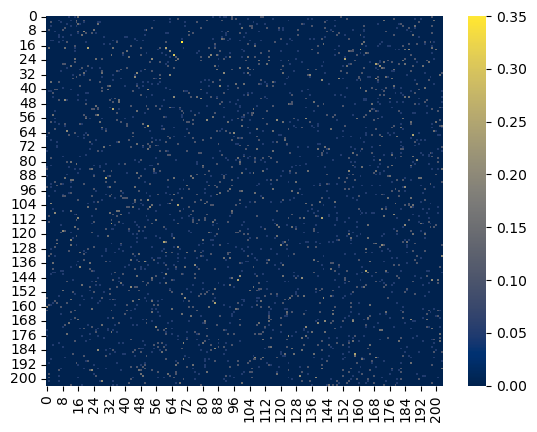

In [15]:
# HADSP + multi
Win_hadsp_multi, W_hadsp_multi, bias_hadsp_multi, connectivity_band, sr_hadsp_multi = initialise_and_train(input_scaling, n, bias_scaling, SEED, frequency_bands)

# 3rd (random + multi)
Win_random_multi, W_random_multi, bias_random_multi =  init_matrices(n, 1, connectivity_band, sr_hadsp_multi)
bias_random_multi= bias_random_multi*bias_scaling
Win_random_multi= Win_random_multi*input_scaling

eigen_random_multi = sparse.linalg.eigs(W_random_multi, k=1, which="LM", maxiter=W_random_multi.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_random_multi = max(abs(eigen_random_multi))

heatmap(W_hadsp_multi.todense(), cmap=color_palette("cividis", as_cmap=True))

### Univariate matrices

In [16]:
if not is_multivariate:
    # HADSP + uni
    Win_hadsp_uni, W_hadsp_uni, bias_hadsp_uni, connectivity_hadsp_uni, sr_hadsp_uni = initialise_and_train(input_scaling, n, bias_scaling, SEED, X_pretrain.flatten())
    
    # random + uni
    Win_normal, W_normal, bias_normal =  init_matrices(n, 1, connectivity_hadsp_uni)
    bias_normal= bias_normal*bias_scaling
    Win_normal= Win_normal*input_scaling   
    
    eigen_normal = sparse.linalg.eigs(W_normal, k=1, which="LM", maxiter=W_normal.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_normal = max(abs(eigen_normal))
    
    heatmap(W_hadsp_uni.todense(), cmap=color_palette("cividis", as_cmap=True))


### Spectral radius normalisation

In [17]:
print(sr_hadsp_multi)
print(sr_random_multi)
if not is_multivariate:
    print(sr_normal)
    print(sr_hadsp_uni)

1.0373839824863476
1.0373839825334306


In [18]:
# Spectral radius normalisation
normal_sr = 0.99
W_hadsp_multi = W_hadsp_multi/sr_hadsp_multi*normal_sr
W_random_multi = W_random_multi/sr_random_multi*normal_sr
if not is_multivariate:
    W_normal = W_normal/sr_normal*normal_sr
    W_hadsp_uni = W_hadsp_uni/sr_hadsp_uni*normal_sr

# Performance

In [19]:
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score

N_JOBS = -1
RIDGE_COEF = 1e-7

## Classification

### Classification for multivariate

In [20]:
# We give Xtrain_band and Xtest_band the same shape as the expected input of the reservoir
caca = []
caca_test = []
for i in tqdm(range(len(X_train_band))):
    if common_xtrain_index == 1:
        caca.append(np.repeat(X_train_band[i], K, axis=1))
    else:
        caca.append(np.repeat(X_train_band[i], K, axis=0).T) # correct axis depends on X_train_band shape
for i in tqdm(range(len(X_test_band))):
    if common_xtrain_index == 1:
        caca_test.append(np.repeat(X_test_band[i], K, axis=1))
    else:
        caca_test.append(np.repeat(X_test_band[i], K, axis=0).T)

print("caca example shape :", caca[1].shape)     
print("We should have :", caca[0].shape[1], "==", n)

100%|████████████████████████████████████████████████████████████████████| 370/370 [00:00<00:00, 55873.72it/s]

caca example shape : (26, 204)
We should have : 204 == 204


In [21]:
from performances.esn_model_evaluation import train_and_predict_model, compute_score
# To remember : 
#  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias

Y_pred_hadsp_multi = train_and_predict_model(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, activation_function, RIDGE_COEF, caca, caca_test, Y_train, N_JOBS)

Y_pred_random_multi = train_and_predict_model(W_random_multi, Win_random_multi, bias_random_multi, activation_function, RIDGE_COEF, caca, caca_test, Y_train, N_JOBS)


Running Reservoir-0: 100%|██████████| 11/11 [00:00<00:00, 26319.08it/s]

Running Reservoir-0: 100%|██████████| 17/17 [00:00<00:00, 10591.68it/s]

Running Reservoir-0: 100%|██████████| 19/19 [00:00<00:00, 5565.07it/s]]

Running Reservoir-0: 100%|██████████| 17/17 [00:00<00:00, 9169.65it/s]

Running Reservoir-0: 100%|██████████| 20/20 [00:00<00:00, 29238.79it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]1it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 38130.04it/s]

Running Reservoir-0: 100%|██████████| 18/18 [00:00<00:00, 29653.37it/s]

Running Reservoir-0: 100%|██████████| 21/21 [00:00<00:00, 31300.78it/s]

Running Reservoir-0: 100%|██████████| 17/17 [00:00<00:00, 30628.51it/s]

Running Ridge-0: 100%|██████████| 1/1 [00:00<00:00, 53092.46it/s]7it/s]

Running Reservoir-0: 100%|██████████| 13/13 [00:00<00:00, 30309.03it/s]

Running Reservoir-0:   0%|          | 0/16 [00:00<?, ?it/s]2it/s]

Running Reservoir-0:   0%|          | 0/18 [00:00<?, ?it/s]247.2

In [22]:
score = compute_score(Y_pred_hadsp_multi, Y_test, "HADSP multi")

score = compute_score(Y_pred_random_multi, Y_test, "random multi")

Accuracy for HADSP multi: 97.027 %
Accuracy for random multi: 95.946 %


### Classification for univariate

In [24]:
if not is_multivariate: 
    # Create a list to store the arrays with the same shape as the expected input of the reservoir
    pipi = []
    pipi_test = []
    
    for i in tqdm(range(len(X_train))):
        pipi.append(np.repeat(X_train[i], n, axis=1))

    for i in tqdm(range(len(X_test))):
        pipi_test.append(np.repeat(X_test[i], n, axis=1))

    print("pipi example shape :", pipi[0].shape)     
    print("We should have :", pipi[0].shape[1], "==", n)

In [25]:
if not is_multivariate:
    Y_pred_hadsp_uni = train_and_predict_model(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, activation_function, RIDGE_COEF, pipi, pipi_test, Y_train, N_JOBS)
    
    Y_pred_normal = train_and_predict_model(W_normal, Win_normal, bias_normal, activation_function, RIDGE_COEF, pipi, pipi_test, Y_train, N_JOBS)

In [26]:
if not is_multivariate:
    score = compute_score(Y_pred_hadsp_uni, Y_test, "HADSP uni")

    score = compute_score(Y_pred_normal, Y_test, "random uni")

## Prediction ahead

### Training

In [ ]:
caca = np.repeat(np.squeeze(np.array(X_train_band)), K, axis=0)
caca_test = np.repeat(np.squeeze(np.array(X_test_band)), K, axis=0)

print("Step ahead : ", step_ahead)

In [ ]:
caca.shape

In [ ]:
import reservoir.reservoir
from reservoir.reservoir import train
reload(reservoir.reservoir)

# To remember
np.zeros(2000)

# to generate the evaluation dataset

# Training random + MG
Wout_normal, b_out_normal, last_state_normal = train(W_normal, Win_normal, bias_normal, X_train, Y_train, activation_function, ridge_coef = RIDGE_COEF)

# Training for HADSP + MG
Wout_hadsp_uni, b_out_hadsp_uni, last_state_hadsp_uni = train(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, X_train, Y_train, activation_function, ridge_coef = RIDGE_COEF)

# Training random + bandfilter
Wout_random_multi, b_out_random_multi, last_state_random_multi = train(W_random_multi, Win_random_multi, bias_random_multi, caca, Y_train, activation_function, ridge_coef = RIDGE_COEF)

# Training output HASDP + bandfilter
Wout_hadsp_multi, b_out_hadsp_multi, last_state_hadsp_multi = train(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, caca, Y_train, activation_function, ridge_coef = RIDGE_COEF)

### Prediction

In [ ]:
from reservoir.reservoir import run
from reservoir.reservoirpy_util import plot_results, plot_readout

# Prediction for random + MG
y_pred_normal = run(W_normal, Win_normal, bias_normal, Wout_normal, X_test, activation_function, b_out_normal, last_state_normal)

# Prediction for HADSP + MG
y_pred_hadsp_uni = run(W_hadsp_uni, Win_hadsp_uni, bias_hadsp_uni, Wout_hadsp_uni, X_test, activation_function, b_out_hadsp_uni, last_state_hadsp_uni)

# Prediction for random + bandfilter
y_pred_random_multi = run(W_random_multi, Win_random_multi, bias_random_multi, Wout_random_multi, caca_test, activation_function, b_out_random_multi, last_state_random_multi)

# Prediction for HADSP + bandfilter
y_pred_hadsp_multi = run(W_hadsp_multi, Win_hadsp_multi, bias_hadsp_multi, Wout_hadsp_multi, caca_test, activation_function, b_out_hadsp_multi, last_state_hadsp_multi)


plot_results(y_pred_random_multi, Y_test, sample=400)


In [ ]:
import reservoir.losses
from reservoir.losses import rmse, nrmse
reload(reservoir.losses)

print("nrmse normal        :", float(nrmse(Y_test[:300], y_pred_normal[:300])))
print("nrmse hadsp     :", float(nrmse(Y_test[:300], y_pred_hadsp_uni[:300])))
print("nrmse random + band :", float(nrmse(Y_test[:300], y_pred_random_multi[:300])))
print("nrmse hadsp + band   :", float(nrmse(Y_test[:300], y_pred_hadsp_multi[:300])))

In [ ]:
nrmse_array_normal = []
nrmse_array_hadsp_multi = []
nrmse_array_random_multi = []
nrmse_array_mg = []

for i in range(len(Y_test)-100- step_ahead):
    Y_test_i = Y_test[i:100+i]
    nrmse_array_normal.append(nrmse(Y_test_i, y_pred_normal[i:100+i]))
    nrmse_array_hadsp_multi.append(nrmse(Y_test_i, y_pred_hadsp_multi[i:100+i]))
    nrmse_array_random_multi.append(nrmse(Y_test_i, y_pred_random_multi[i:100+i]))
    nrmse_array_mg.append(nrmse(Y_test_i, y_pred_hadsp_multi[i:100+i]))
    
log10_nrmse_normal = np.log10(nrmse_array_normal)
log10_nrmse_hadsp_multi = np.log10(nrmse_array_hadsp_multi)
log10_nrmse_random_multi = np.log10(nrmse_array_random_multi)
log10_nrmse_mg = np.log10(nrmse_array_mg)
plt.figure()
plt.plot(log10_nrmse_normal[:1000])
plt.plot(log10_nrmse_hadsp_multi[:1000])
plt.plot(log10_nrmse_random_multi[:1000])
plt.plot(log10_nrmse_mg[:1000])

plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["HADSP+band", "random", " random + bandfilter", "HADSP"])
plt.show()

# Analysis

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from collections import defaultdict
from scipy.sparse import coo_matrix

def plot_connectivity(coo):
    G = nx.DiGraph()

    # Convert coo_matrix to edge list and add edges to the graph
    for node1, node2 in zip(coo.row, coo.col):
        G.add_edge(node1, node2)

    triad_connections = defaultdict(int)

    # Get all sets of 3 nodes
    for nodes in combinations(G.nodes, 3):
        # For each node in the triad, count its incoming and outgoing connections within the triad
        connectivity_states = []
        for node in nodes:
            in_edges = sum([G.has_edge(other, node) for other in nodes if other != node])
            out_edges = sum([G.has_edge(node, other) for other in nodes if other != node])
            connectivity_states.append((in_edges, out_edges))
        # Sort the connectivity states so that equivalent triads have the same key, regardless of node order
        connectivity_states = tuple(sorted(connectivity_states))
        triad_connections[connectivity_states] += 1

    # Sort results by total number of connections
    sorted_results = sorted(((sum(in_edges for in_edges, out_edges in key) + sum(out_edges for in_edges, out_edges in key), key) for key in triad_connections.items()), key=lambda x: x[0])
    sorted_labels = [str(key) for total, key in sorted_results]
    sorted_values = [triad_connections[key] for total, key in sorted_results]

    # Plot results
    plt.bar(range(len(sorted_labels)), sorted_values, tick_label=sorted_labels)
    plt.xlabel('Triad connectivity state')
    plt.ylabel('Count')
    plt.title('Triad Connection Count in Graph')
    plt.xticks(rotation=90)
    plt.show()


plot_connectivity(W_normal)

In [ ]:
plot_connectivity(W_hadsp_multi)

In [ ]:
time_series = filtered_data
# Create a matrix to hold the mutual information between each pair of time series
mi_matrix = np.zeros((len(time_series), len(time_series)))

    
# Function to compute mutual information
def compute_mi(i, j):
    # Discretize the data
    time_series_i_discrete = np.floor(time_series[i] * 10).astype(int)
    time_series_j_discrete = np.floor(time_series[j] * 10).astype(int)
    
    # Compute mutual information
    mi = mutual_info_score(time_series_i_discrete, time_series_j_discrete)
    
    return i, j, mi

# Create a list of all pairs of indices
indices = [(i, j) for i in range(len(time_series)) for j in range(i, len(time_series))]



# Use joblib to parallelize the computation
results = Parallel(n_jobs=-1, backend="threading", verbose=1)(delayed(compute_mi)(i, j) for i, j in indices)

# Store the results in the matrix
for i, j, mi in results:
    mi_matrix[i, j] = mi
    mi_matrix[j, i] = mi

pbar.close()

heatmap(mi_matrix)